## Importing Libraries

In [1]:
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

## Capacity Defining

In [2]:
NUM_CUSTOMERS = 100
NUM_VEHICLES = 5
VEHICLE_CAPACITY = 20
DEPOT_LOCATION = (0, 0)


np.random.seed(12243493)  # For reproducibility created a seed
customer_locations = np.random.rand(NUM_CUSTOMERS, 2) * 100  # Random locations within a 100x100 grid
customer_demands = np.random.randint(1, 10, NUM_CUSTOMERS)  # Random demands between 1 and 10

# Helper function to calculate Euclidean distance that measures the distance
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


distance_matrix = np.zeros((NUM_CUSTOMERS + 1, NUM_CUSTOMERS + 1))  # +1 to include depot
for i in range(NUM_CUSTOMERS):
    for j in range(NUM_CUSTOMERS):
        distance_matrix[i + 1][j + 1] = euclidean_distance(customer_locations[i], customer_locations[j])
    distance_matrix[0][i + 1] = distance_matrix[i + 1][0] = euclidean_distance(DEPOT_LOCATION, customer_locations[i])

class VRPEnvironment:
    def __init__(self, num_customers, num_vehicles, vehicle_capacity, depot_location, customer_locations, customer_demands):
        self.num_customers = num_customers
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.depot_location = depot_location
        self.customer_locations = customer_locations
        self.customer_demands = customer_demands
        self.distance_matrix = distance_matrix

vrp_env = VRPEnvironment(NUM_CUSTOMERS, NUM_VEHICLES, VEHICLE_CAPACITY, DEPOT_LOCATION, customer_locations, customer_demands)

Validates the solution to ensure each customer is visited exactly once. Checksif all customers -1 through num_customers are visited without duplicates or omissions.


In [3]:
def validate_unique_customer_visits(solution, num_customers):
    visited_customers = set(customer for route in solution for customer in route)
    if len(visited_customers) == num_customers and len(visited_customers) == sum(len(route) for route in solution):
        print("Validation Passed: Each customer is visited exactly once.")
    else:
        missing_customers = set(range(1, num_customers + 1)) - visited_customers
        duplicate_customers = [customer for customer in visited_customers if list(visited_customers).count(customer) > 1]
        print(f"Validation Failed. Missing customers: {missing_customers}")
        print(f"Duplicate customers: {duplicate_customers}")


## Genetic Algorithms

In [15]:
class GeneticAlgorithmVRP_FinalCoverage:
    def __init__(self, vrp_env, population_size=20, generations=50, crossover_rate=0.8, mutation_rate=0.1):
        self.vrp_env = vrp_env
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = []

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            chromosome = self.unique_solution()
            population.append(chromosome)
        self.population = population

    def unique_solution(self):
        solution = [[] for _ in range(self.vrp_env.num_vehicles)]
        customer_indices = list(range(1, self.vrp_env.num_customers + 1))
        random.shuffle(customer_indices)

        vehicle_idx = 0
        current_load = 0

        for customer in customer_indices:
            demand = self.vrp_env.customer_demands[customer - 1]
            if current_load + demand > self.vrp_env.vehicle_capacity or len(solution[vehicle_idx]) >= VEHICLE_CAPACITY:
                vehicle_idx = (vehicle_idx + 1) % self.vrp_env.num_vehicles
                current_load = 0
            solution[vehicle_idx].append(customer)
            current_load += demand

        for vehicle_route in solution:
            if len(vehicle_route) < VEHICLE_CAPACITY:
                missing_count = 20 - len(vehicle_route)
                vehicle_route.extend(customer_indices[:missing_count])
                customer_indices = customer_indices[missing_count:]

        return solution

    def fitness(self, chromosome):
        total_distance = 0
        for route in chromosome:
            if route:
                route_distance = self.vrp_env.distance_matrix[0][route[0]]
                for i in range(len(route) - 1):
                    route_distance += self.vrp_env.distance_matrix[route[i]][route[i + 1]]
                route_distance += self.vrp_env.distance_matrix[route[-1]][0]
                total_distance += route_distance
        return total_distance

    def selection(self):
        ranked_population = sorted(self.population, key=self.fitness)
        return ranked_population[:self.population_size // 2]

    def crossover(self, parent1, parent2):
        child1, child2 = [[] for _ in range(self.vrp_env.num_vehicles)], [[] for _ in range(self.vrp_env.num_vehicles)]
        for vehicle_idx in range(self.vrp_env.num_vehicles):
            split_point = len(parent1[vehicle_idx]) // 2
            child1[vehicle_idx] = parent1[vehicle_idx][:split_point] + parent2[vehicle_idx][split_point:]
            child2[vehicle_idx] = parent2[vehicle_idx][:split_point] + parent1[vehicle_idx][split_point:]

        return self.enforce_uniqueness(child1), self.enforce_uniqueness(child2)

    def enforce_uniqueness(self, chromosome):
        all_customers = set(range(1, self.vrp_env.num_customers + 1))
        assigned_customers = set(customer for route in chromosome for customer in route)
        missing_customers = list(all_customers - assigned_customers)

        for route in chromosome:
            unique_route = []
            current_load = 0
            for customer in route:
                if customer not in unique_route and current_load + self.vrp_env.customer_demands[customer - 1] <= self.vrp_env.vehicle_capacity:
                    unique_route.append(customer)
                    current_load += self.vrp_env.customer_demands[customer - 1]
            route.clear()
            route.extend(unique_route)

        for customer in missing_customers:
            for route in chromosome:
                current_demand = sum(self.vrp_env.customer_demands[cust - 1] for cust in route)
                if current_demand + self.vrp_env.customer_demands[customer - 1] <= self.vrp_env.vehicle_capacity:
                    route.append(customer)
                    break

        return chromosome

    def mutate(self, chromosome):
        if random.random() < self.mutation_rate:
            route1, route2 = random.sample(chromosome, 2)
            if route1 and route2:
                idx1, idx2 = random.randint(0, len(route1) - 1), random.randint(0, len(route2) - 1)
                route1[idx1], route2[idx2] = route2[idx2], route1[idx1]
        return self.enforce_uniqueness(chromosome)

    def ensure_full_coverage(self, solution):
        all_customers = set(range(1, self.vrp_env.num_customers + 1))
        assigned_customers = set(customer for route in solution for customer in route)
        missing_customers = list(all_customers - assigned_customers)

        for customer in missing_customers:
            for route in solution:
                current_demand = sum(self.vrp_env.customer_demands[cust - 1] for cust in route)
                if current_demand + self.vrp_env.customer_demands[customer - 1] <= self.vrp_env.vehicle_capacity:
                    route.append(customer)
                    break

        for route in solution:
            if len(route) < 20:
                additional_customers = missing_customers[:20 - len(route)]
                route.extend(additional_customers)
                missing_customers = missing_customers[len(additional_customers):]

        return solution

    def evolve(self):
        self.initialize_population()
        best_solution = None
        best_distance = float('inf')
        convergence_progress = []


        for generation in range(self.generations):
            selected_population = self.selection()
            offspring = []
            for _ in range(len(selected_population) // 2):
                parent1, parent2 = random.sample(selected_population, 2)
                child1, child2 = self.crossover(parent1, parent2)
                offspring.append(self.mutate(child1))
                offspring.append(self.mutate(child2))

            self.population = [self.ensure_full_coverage(individual) for individual in (selected_population + offspring)]
            current_best = min(self.population, key=self.fitness)
            current_distance = self.fitness(current_best)
            convergence_progress.append(current_distance)

            if current_distance < best_distance:
                best_distance = current_distance
                best_solution = current_best
        best_solution = self.ensure_full_coverage(best_solution)
        return best_solution, best_distance, convergence_progress

    def solve(self):
        best_solution, best_distance, convergence_progress = self.evolve()
        return best_solution, best_distance, convergence_progress


start_time = time.time()

final_coverage_ga_vrp = GeneticAlgorithmVRP_FinalCoverage(vrp_env)
best_final_coverage_solution, best_final_coverage_distance_ga, convergence_progress_ga = final_coverage_ga_vrp.evolve()

end_time = time.time()
total_time = end_time - start_time

print("Best Distance with Complete Coverage:", best_final_coverage_distance_ga)
print("Best Solution with Complete Coverage:", best_final_coverage_solution)
print("Total Runtime for Evolution Process:", total_time, "seconds")

validate_unique_customer_visits(best_final_coverage_solution, vrp_env.num_customers)



Best Distance with Complete Coverage: 4881.602222471187
Best Solution with Complete Coverage: [[95, 93, 66, 13, 85, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 19], [92, 80, 61, 35, 97, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 36, 38], [72, 64, 87, 56, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57], [37, 84, 60, 18, 58, 59, 62, 63, 65, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78], [94, 40, 39, 14, 28, 4, 29, 79, 81, 82, 83, 86, 88, 89, 90, 91, 96, 98, 99, 100]]
Total Runtime for Evolution Process: 0.9212181568145752 seconds
Validation Passed: Each customer is visited exactly once.


In [16]:
def create_vehicle_summary_table(solution):
    data = []
    for vehicle_id, vehicle_route in enumerate(solution, start=1):
        total_customers = sum(len(sub_route) - sub_route.count(0) for sub_route in vehicle_route)
        data.append({"Vehicle ID": vehicle_id, "Total Customers Visited": total_customers})

summary_df = pd.DataFrame(best_final_coverage_solution)
summary_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,95,93,66,13,85,1,2,3,5,6,7,8,9,10,11,12,15,16,17,19
1,92,80,61,35,97,20,21,22,23,24,25,26,27,30,31,32,33,34,36,38
2,72,64,87,56,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,57
3,37,84,60,18,58,59,62,63,65,67,68,69,70,71,73,74,75,76,77,78
4,94,40,39,14,28,4,29,79,81,82,83,86,88,89,90,91,96,98,99,100


## VRP CA

In [6]:
class CellularAutomataVRP_CapacityConstraint:
    def __init__(self, vrp_env, iterations=50, neighborhood_size=3):
        self.vrp_env = vrp_env
        self.iterations = iterations
        self.neighborhood_size = neighborhood_size
        self.grid = self.initialize_grid()

    def initialize_grid(self):
        grid = []
        unassigned_customers = list(range(1, self.vrp_env.num_customers + 1))
        random.shuffle(unassigned_customers)

        for _ in range(self.vrp_env.num_vehicles):
            solution, unassigned_customers = self.unique_solution(unassigned_customers)
            grid.append(solution)

        if unassigned_customers:
            for customer in unassigned_customers:
                for route in grid:
                    current_load = sum(self.vrp_env.customer_demands[cust - 1] for cust in route)
                    if current_load + self.vrp_env.customer_demands[customer - 1] <= self.vrp_env.vehicle_capacity:
                        route.append(customer)
                        break

        return grid

    def unique_solution(self, unassigned_customers):
        route = []
        current_load = 0
        remaining_customers = unassigned_customers.copy()

        for customer in remaining_customers:
            demand = self.vrp_env.customer_demands[customer - 1]
            if current_load + demand <= self.vrp_env.vehicle_capacity:
                route.append(customer)
                current_load += demand
                unassigned_customers.remove(customer)

        return route, unassigned_customers

    def enforce_capacity_and_uniqueness(self):
        all_customers = set(range(1, self.vrp_env.num_customers + 1))
        assigned_customers = set(customer for route in self.grid for customer in route)
        missing_customers = list(all_customers - assigned_customers)

        for route in self.grid:
            seen = set()
            unique_route = []
            current_load = 0
            for customer in route:
                demand = self.vrp_env.customer_demands[customer - 1]
                if customer not in seen and current_load + demand <= self.vrp_env.vehicle_capacity:
                    unique_route.append(customer)
                    seen.add(customer)
                    current_load += demand
            route.clear()
            route.extend(unique_route)

        for customer in missing_customers:
            for route in self.grid:
                current_demand = sum(self.vrp_env.customer_demands[cust - 1] for cust in route)
                if current_demand + self.vrp_env.customer_demands[customer - 1] <= self.vrp_env.vehicle_capacity:
                    route.append(customer)
                    break


    def reassign_missing_customers(self):
        all_customers = set(range(1, self.vrp_env.num_customers + 1))
        assigned_customers = set(customer for route in self.grid for customer in route)
        missing_customers = list(all_customers - assigned_customers)

        for customer in missing_customers:
            assigned = False
            for route in self.grid:
                current_demand = sum(self.vrp_env.customer_demands[cust - 1] for cust in route)
                if current_demand + self.vrp_env.customer_demands[customer - 1] <= self.vrp_env.vehicle_capacity:
                    route.append(customer)
                    assigned = True
                    break

            if not assigned:
                min_route = min(self.grid, key=lambda r: sum(self.vrp_env.customer_demands[cust - 1] for cust in r))
                min_route.append(customer)
    def evolve(self):
        convergence_progress = []  # To save the best distance over iterations
        for iteration in range(self.iterations):
            self.enforce_capacity_and_uniqueness()
            self.reassign_missing_customers()

            for route in self.grid:
                assert isinstance(route, list), f"Route is not a list: {route}"
                assert all(isinstance(customer, int) for customer in route), f"Invalid customer in route: {route}"

            total_distance = self.calculate_solution_cost(self.grid)
            convergence_progress.append(total_distance)

        return self.grid, convergence_progress


    def calculate_solution_cost(self, solution):
        total_distance = 0
        for route in solution:
            if not isinstance(route, list):
                raise ValueError(f"Invalid route structure: {route}")
            if route and (route[0] < 1 or route[-1] > self.vrp_env.num_customers):
                raise ValueError(f"Invalid customer index in route: {route}")
            if route:
                distance = self.vrp_env.distance_matrix[0][route[0]]
                for i in range(len(route) - 1):
                    distance += self.vrp_env.distance_matrix[route[i]][route[i + 1]]
                distance += self.vrp_env.distance_matrix[route[-1]][0]
                total_distance += distance
        return total_distance
    def solve(self):
        final_solution, convergence_progress = self.evolve()
        for route in final_solution:
            assert isinstance(route, list), f"Route is not a list: {route}"
            assert all(isinstance(customer, int) for customer in route), f"Invalid customer in route: {route}"
        total_distance = self.calculate_solution_cost(final_solution)
        return final_solution, total_distance, convergence_progress

start_time = time.time()

ca_vrp_with_capacity = CellularAutomataVRP_CapacityConstraint(vrp_env)
final_solution_with_capacity, convergence_progress_ca = ca_vrp_with_capacity.evolve()
total_distance = ca_vrp_with_capacity.calculate_solution_cost(final_solution_with_capacity)

end_time = time.time()
total_time = end_time - start_time

print("Final Distance with Capacity Constraints:", total_distance)
print("Total Runtime for Cellular Automata Process:", total_time, "seconds")
print("Number of Vehicles:", len(final_solution_with_capacity))
print("Number of Customers:", sum(len(route) for route in final_solution_with_capacity))
validate_unique_customer_visits(final_solution_with_capacity, vrp_env.num_customers)


Final Distance with Capacity Constraints: 5360.862771706644
Total Runtime for Cellular Automata Process: 0.42511796951293945 seconds
Number of Vehicles: 5
Number of Customers: 100
Validation Passed: Each customer is visited exactly once.


In [7]:
def create_vehicle_summary_table(solution):
    data = []
    for vehicle_id, vehicle_route in enumerate(solution, start=1):
        if isinstance(vehicle_route[0], list):
            total_customers = sum(len(sub_route) - sub_route.count(0) for sub_route in vehicle_route)
        else:
            total_customers = len(vehicle_route) - vehicle_route.count(0)
        data.append({"Vehicle ID": vehicle_id, "Total Customers Visited": total_customers})
    summary_df = pd.DataFrame(data)
    return summary_df

vehicle_summary_df = create_vehicle_summary_table(final_solution_with_capacity)
print("Vehicle Summary:")
vehicle_summary_df

Vehicle Summary:


,Vehicle ID,Total Customers Visited
0,1,21
1,2,19
2,3,25
3,4,16
4,5,19


## VRP ACO

In [8]:
class AntColonyOptimizationVRP_Unique:
    def __init__(self, vrp_env, num_ants=20, iterations=50, evaporation_rate=0.5, pheromone_influence=1, distance_influence=5):
        self.vrp_env = vrp_env
        self.num_ants = num_ants
        self.iterations = iterations
        self.evaporation_rate = evaporation_rate
        self.pheromone_influence = pheromone_influence
        self.distance_influence = distance_influence
        self.pheromone_matrix = np.ones((vrp_env.num_customers + 1, vrp_env.num_customers + 1))

    def initialize_ant_route(self):
        return [[] for _ in range(self.vrp_env.num_vehicles)]

    def calculate_route_length(self, route):
        if not route:
            return float('inf')
        distance = self.vrp_env.distance_matrix[0][route[0]]
        for i in range(len(route) - 1):
            distance += self.vrp_env.distance_matrix[route[i]][route[i + 1]]
        distance += self.vrp_env.distance_matrix[route[-1]][0]
        return distance

    def calculate_solution_cost(self, solution):
        return sum(self.calculate_route_length(route) for route in solution)

    def choose_next_customer(self, current_customer, unvisited, vehicle_load):
        probabilities = []
        for customer in unvisited:
            demand = self.vrp_env.customer_demands[customer - 1]
            if vehicle_load + demand > self.vrp_env.vehicle_capacity:
                probabilities.append(0)
            else:
                pheromone = self.pheromone_matrix[current_customer][customer] ** self.pheromone_influence
                distance = (1 / self.vrp_env.distance_matrix[current_customer][customer]) ** self.distance_influence
                probabilities.append(pheromone * distance)

        total_prob = sum(probabilities)
        if total_prob == 0:
            return None

        probabilities = [p / total_prob for p in probabilities]
        return np.random.choice(unvisited, p=probabilities)

    def simulate_ant(self):
        solution = self.initialize_ant_route()
        unvisited = list(range(1, self.vrp_env.num_customers + 1))

        for vehicle_route in solution:
            vehicle_load = 0
            current_customer = 0
            while unvisited:
                next_customer = self.choose_next_customer(current_customer, unvisited, vehicle_load)
                if next_customer is None:
                    break
                vehicle_route.append(next_customer)
                vehicle_load += self.vrp_env.customer_demands[next_customer - 1]
                unvisited.remove(next_customer)
                current_customer = next_customer
        self.enforce_solution_uniqueness(solution, unvisited)
        return solution

    def enforce_solution_uniqueness(self, solution, unvisited):
        missing_customers = unvisited.copy()

        for route in solution:
            route_demand = sum(self.vrp_env.customer_demands[customer - 1] for customer in route)
            while missing_customers and route_demand + self.vrp_env.customer_demands[missing_customers[0] - 1] <= self.vrp_env.vehicle_capacity:
                customer = missing_customers.pop(0)
                route.append(customer)
                route_demand += self.vrp_env.customer_demands[customer - 1]

        if missing_customers:
            for customer in missing_customers:
                min_route = min(solution, key=lambda r: len(r))
                min_route.append(customer)


    def update_pheromones(self, solutions):
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        for solution, cost in solutions:
            for route in solution:
                for i in range(len(route) - 1):
                    self.pheromone_matrix[route[i]][route[i + 1]] += 1 / cost
                    self.pheromone_matrix[route[i + 1]][route[i]] += 1 / cost
                    self.pheromone_matrix[0][route[0]] += 1 / cost
                    self.pheromone_matrix[route[-1]][0] += 1 / cost

    def optimize(self):
        best_solution = None
        best_distance = float('inf')
        convergence_progress = []

        for _ in range(self.iterations):
            ant_solutions = [(self.simulate_ant(), None) for _ in range(self.num_ants)]
            for i, (solution, _) in enumerate(ant_solutions):
                cost = self.calculate_solution_cost(solution)
                ant_solutions[i] = (solution, cost)
                if cost < best_distance:
                    best_distance = cost
                    best_solution = solution

            self.update_pheromones(ant_solutions)

            convergence_progress.append(best_distance)

        return best_solution, best_distance, convergence_progress

    def solve(self):
        best_solution, best_distance, convergence_progress = self.optimize()
        return best_solution, best_distance, convergence_progress

start_time = time.time()
unique_aco_vrp = AntColonyOptimizationVRP_Unique(vrp_env)
best_unique_aco_solution, best_unique_aco_distance, convergence_progress = unique_aco_vrp.solve()
end_time = time.time()
total_time = end_time - start_time

print("Best Distance with Complete Coverage:", best_unique_aco_distance)
print("Best Solution with Complete Coverage (first few routes):", best_unique_aco_solution[:6])
print("Total Runtime for ACO Process:", total_time, "seconds")

validate_unique_customer_visits(best_unique_aco_solution, vrp_env.num_customers)


Best Distance with Complete Coverage: 4092.5576808021324
Best Solution with Complete Coverage (first few routes): [[84, 41, 61, 51, 52, 4, 9, 16, 23, 29, 36, 43, 48, 55, 62, 71, 77, 82, 90, 95], [63, 17, 75, 28, 10, 5, 11, 18, 24, 31, 38, 44, 49, 57, 65, 72, 78, 83, 91, 96], [56, 22, 32, 1, 2, 6, 12, 19, 25, 33, 39, 45, 50, 58, 66, 73, 79, 85, 92, 97], [30, 70, 69, 64, 3, 7, 13, 20, 26, 34, 40, 46, 53, 59, 67, 74, 80, 86, 93, 98], [88, 37, 15, 87, 99, 8, 14, 21, 27, 35, 42, 47, 54, 60, 68, 76, 81, 89, 94, 100]]
Total Runtime for ACO Process: 8.452030420303345 seconds
Validation Passed: Each customer is visited exactly once.


In [9]:
def create_vehicle_summary_table(solution):
    data = []
    for vehicle_id, vehicle_route in enumerate(solution, start=1):
        if isinstance(vehicle_route[0], list):
            total_customers = sum(len(sub_route) - sub_route.count(0) for sub_route in vehicle_route)
        else:
            total_customers = len(vehicle_route) - vehicle_route.count(0)
        data.append({"Vehicle ID": vehicle_id, "Total Customers Visited": total_customers})
    summary_df = pd.DataFrame(data)
    return summary_df

vehicle_summary_df = create_vehicle_summary_table(best_unique_aco_solution)
print("Vehicle Summary:")
vehicle_summary_df


Vehicle Summary:


,Vehicle ID,Total Customers Visited
0,1,20
1,2,20
2,3,20
3,4,20
4,5,20


## Comparisons

In [10]:
def compare_vrp_algorithms(vrp_env, algorithms):
    results = []
    all_convergence = {}

    for name, algo in algorithms.items():
        start_time = time.time()
        solution, best_distance, convergence_progress = algo.solve()
        end_time = time.time()

        runtime = end_time - start_time
        results.append({
            "Algorithm": name,
            "Best Distance": best_distance,
            "Runtime (seconds)": runtime
        })
        all_convergence[name] = convergence_progress

    results_df = pd.DataFrame(results)
    return results_df, all_convergence


In [11]:
def plot_results(results_df, convergence_data):
    plt.figure()
    plt.bar(results_df['Algorithm'], results_df['Runtime (seconds)'], color='skyblue')
    plt.title('Runtime Comparison')
    plt.xlabel('Algorithm')
    plt.ylabel('Runtime (seconds)')
    plt.show()

    for algo_name, convergence in convergence_data.items():
        plt.plot(convergence, label= algo_name)
    plt.title('Convergence Trends')
    plt.xlabel('Iterations/Generations')
    plt.ylabel('Fitness (Distance)')
    plt.legend()
    plt.show()


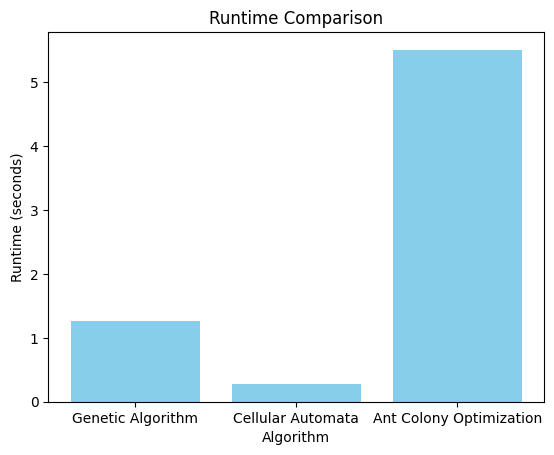

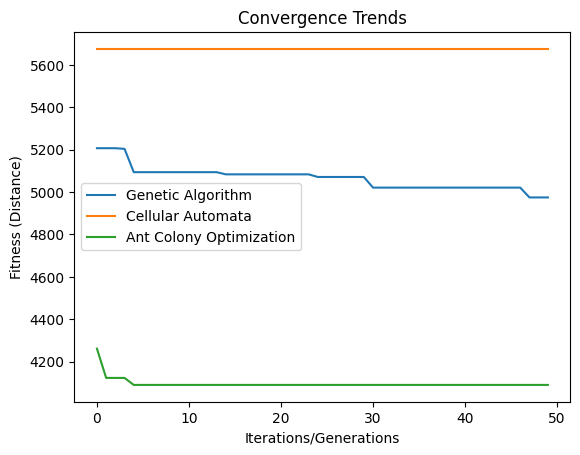

In [12]:
genetic_algo = GeneticAlgorithmVRP_FinalCoverage(vrp_env)
cellular_automata = CellularAutomataVRP_CapacityConstraint(vrp_env)
ant_colony = AntColonyOptimizationVRP_Unique(vrp_env)

algorithms = {
    "Genetic Algorithm": genetic_algo,
    "Cellular Automata": cellular_automata,
    "Ant Colony Optimization": ant_colony
}

results_df, convergence_data = compare_vrp_algorithms(vrp_env, algorithms)
plot_results(results_df, convergence_data)
